# Database Loading & Pre-process

In this Notebook we developed a code to load the entire Kaggle Respiration Sound Database and pre-process each of the signals

### References

[1] Kaggle:
        https://www.kaggle.com/vbookshelf/respiratory-sound-database

[2] Librosa demo:
        https://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

### Libraries Needed

In [1]:
from ipywidgets import widgets, interact

import numpy as np
import librosa as lb
from tqdm import tqdm
import soundfile as sfile
import librosa.display as lbdis
import matplotlib.pyplot as plt
%matplotlib inline


# changing to database path
import os
import sys
from os.path import dirname as up
mf_path = (up(os.getcwd())).replace('\\','/')    # Main Folder Path
sys.path.insert(1, mf_path)

import aidiagnostics_toolbox as aidt
import glob
os.chdir(mf_path + '/Respiratory_Sound_Database/audio_and_txt_files')

### Data Loading Process

In [2]:
# Initializing Variables
sound_list = []
sound_reco = []
sf_reco = []
# Loading Loop
for file in tqdm(glob.glob("*.wav")):
    sound_list.append(file)
    # Loading and resampling sounds to 2kHz with librosa is too slow
    data, sf = sfile.read(mf_path + '/Respiratory_Sound_Database/audio_and_txt_files/' + file)#, sr = 2000)
    sound_reco.append(data)
    sf_reco.append(sf)
    
print(' -----')
n_sounds = np.shape(sound_list)[0]
print('Number of sound Recordings = ', n_sounds)

100%|███████████████████████████████████████████████████████████████████████████████| 920/920 [00:07<00:00, 130.74it/s]

 -----
Number of sound Recordings =  920


After loading the whole database, we can list each of them:

In [3]:
# List of 3 sounds
print(sound_list[:3])
# print all sounds ..

['101_1b1_Al_sc_Meditron.wav', '101_1b1_Pr_sc_Meditron.wav', '102_1b1_Ar_sc_Meditron.wav']


We can select a single sound from the database to preprocess it

In [4]:
w = widgets.IntSlider(min=0, max=n_sounds, step = 1, value = 10)
display(w)

IntSlider(value=10, max=920)

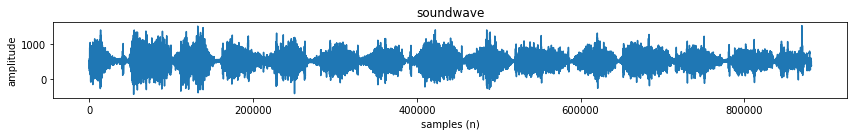

In [5]:
# selecting recording # 2 ... Add slider widget
#@title Select one sound from database
rec = 0 #@param {type:"slider", min:0, max:30, step:1}

X = sound_reco[w.value]
X = aidt.butter_bp_fil(X, 100, 300, sf)

plt.figure(figsize=(12,2))
plt.plot(512+(1000*X))
plt.title('soundwave')
plt.xlabel('samples (n)')
plt.ylabel('amplitude')
plt.tight_layout()

### Mel Spectrogram

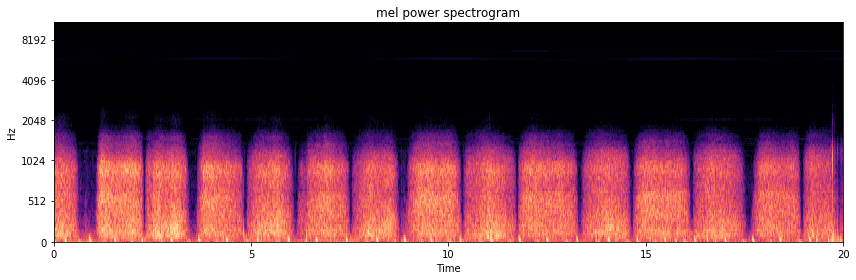

In [6]:
# Mel spectrogram
Mspec = lb.feature.melspectrogram(X, sr=sf, n_mels=128)
# Convert to log scale (dB)
Mspec_db = lb.power_to_db(Mspec, ref=np.max)
# Plotting Mel Spectrogram
plt.figure(figsize=(12,4))
lbdis.specshow(Mspec_db, sr=sf, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.tight_layout()

### Harmonic-percussive source separation

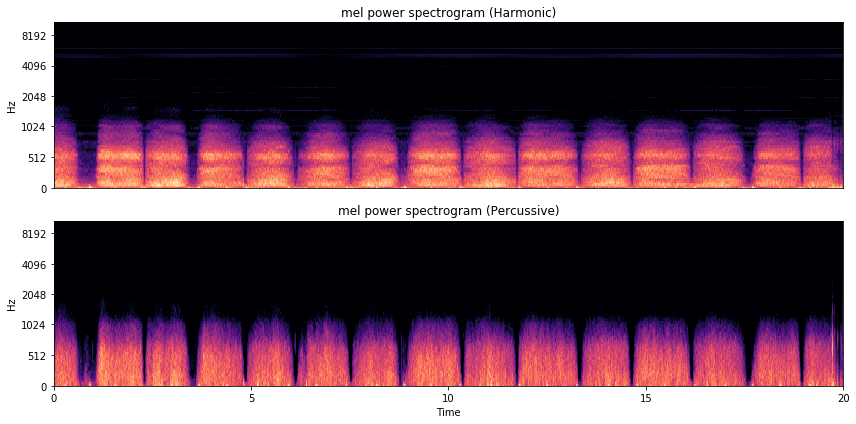

In [7]:
y_harmonic, y_percussive = lb.effects.hpss(X)
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = lb.feature.melspectrogram(y_harmonic)#, sr=sf)
S_percussive = lb.feature.melspectrogram(y_percussive)#, sr=sf)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = lb.power_to_db(S_harmonic, ref=np.max)
log_Sp = lb.power_to_db(S_percussive, ref=np.max)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
lbdis.specshow(log_Sh, sr=sf, y_axis='mel')
plt.title('mel power spectrogram (Harmonic)')
plt.subplot(2,1,2)
lbdis.specshow(log_Sp, sr=sf, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram (Percussive)')
plt.tight_layout()

### Chromagram

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.22s/it]


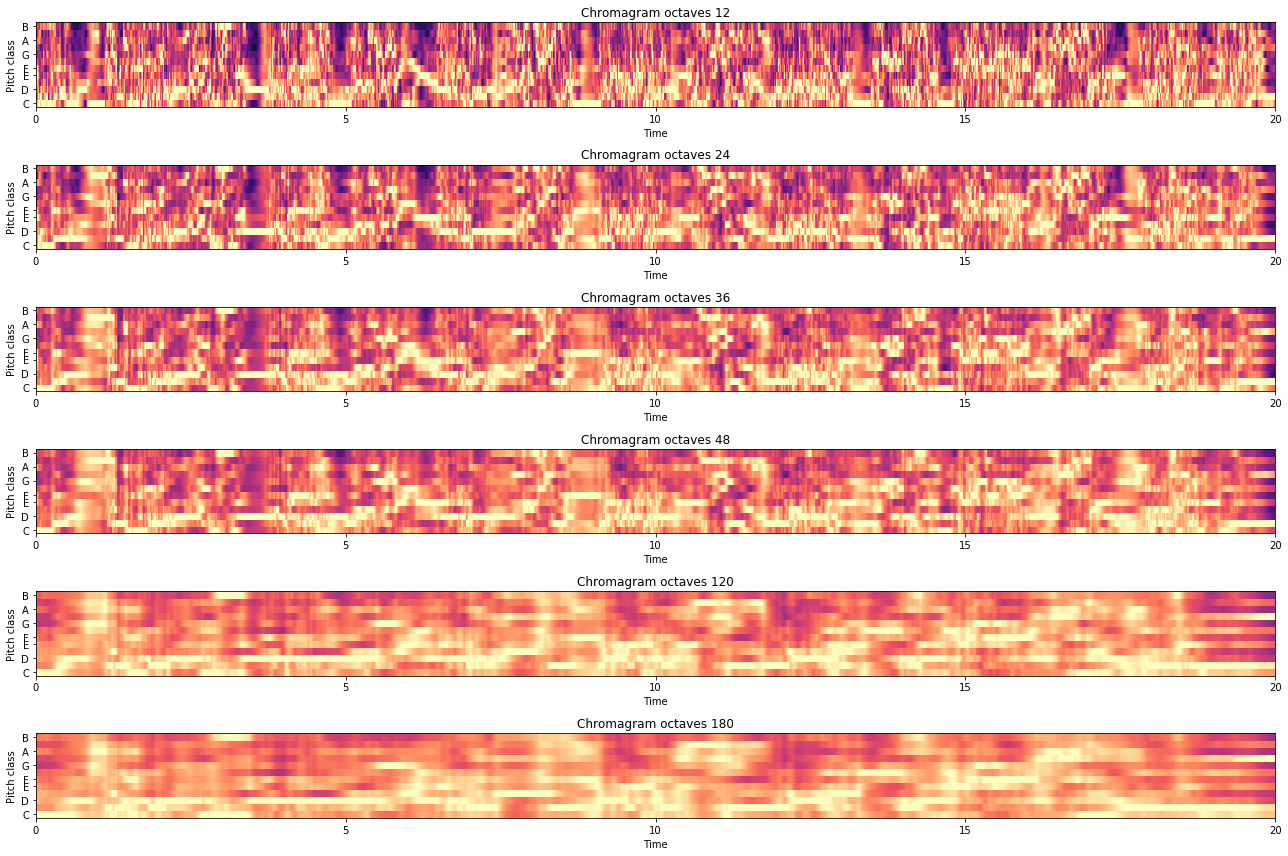

In [8]:
# Make a new figure
plt.figure(figsize=(18,12))
octa_vec = np.array([12, 24, 36, 48, 120, 180])
k = len(octa_vec)
for i in tqdm(range(k)):
    plt.subplot(k,1,i+1)    
    C = lb.feature.chroma_cqt(y=y_harmonic, sr=sf, bins_per_octave=int(octa_vec[i]))
    lbdis.specshow(C, sr=sf, x_axis='time', y_axis='chroma', vmin=0, vmax=1)   
    plt.title('Chromagram octaves %s' % str(octa_vec[i]))

plt.tight_layout()